In [173]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2"; 
import tensorflow as tf
import numpy as np
import pickle
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score
from datapipe import bin_ndarray
#TODO: read tf documentation on what the static_rnn does
#do I want to one hot encode the data? or already too many dimensions

In [174]:
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [175]:
tf.__version__

'1.12.0'

In [230]:
def process_dy(dy):
    (length, y, x) = dy.shape
    newdy = np.zeros((length, y-40, x-50), dtype=np.float16)
    for ind, image in enumerate(dy):
        newimg = image[1:-39, 0:-50]
        newdy[ind] = image[1:-39, 0:-50]
    print(newdy[0].shape)
    return bin_dy(newdy)
    # newdyfile = open('./dfy/cropped_AV_2.pkl', 'wb')
#     np.save('./data/cropped_AV_5.npy', newdy)

In [231]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float16)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [178]:
# #open files, they have not been normalized yet
# dffile = open('masdfr3m1170210s2.pkl',"rb")
# dyfile = open('r3m1170210s2.pkl', "rb")
# df = pickle.load(dffile)
# df = df.drop(columns='pupilCurr', axis=1)
# df = df.drop(columns='pupilPeri', axis=1)
# df = df.interpolate()
# dy = pickle.load(dyfile)
# #dataset2
# dffile = open('masdfr4m7170321s1.pkl',"rb")
# dyfile = open('r4m7170321s1.pkl', "rb")
# df = pickle.load(dffile)
# df = df.drop(columns='pupilCurr', axis=1)
# df = df.drop(columns='pupilPeri', axis=1)
# df = df.interpolate()
# dy = pickle.load(dyfile)

In [232]:
#loading full file on disk, can access small slices without loading into memory
dy = np.load('./data/AV_5.npy', mmap_mode='r')
f = open('./data/delayed_masdfAV_5.pkl', 'rb')
df = pickle.load(f)
(length, y, x) = dy.shape

In [233]:
#10hz data
dfcropped = (df.iloc[::3])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (dy[::3])
dycropped = process_dy(dycropped)
(length, y, x) = dycropped.shape
dycropped = dycropped.reshape(length, y*x)

(600, 590)
(5668, 600, 590)
(5668, 300, 295)


In [ ]:
#15hz data
dfcropped = (df.iloc[::2])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
dycropped = (dy[::2]).reshape((length, y*x))
(length, y, x) = dycropped.shape
dycropped = dycropped.reshape(length, y*x)

In [ ]:
#30hz data 
dfcropped = df[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
(length, y, x) = dy.shape
dycropped = dy.reshape((length, y*x))

In [181]:
print(dfcropped) # do I want to take out lastStimT ??

       stimType  pupilCurr  snoutCurr    jawCurr  wheelCurr  responseT    H  \
0          -1.0   0.123733   0.000000   0.000000   3.012598        0.0  0.0   
3          -1.0   0.124481   8.953110   6.099976   3.012341        0.0  0.0   
6          -1.0   0.125188  10.459808   5.278083   3.012161        0.0  0.0   
9          -1.0   0.126097  10.945455  10.081639   3.012268        0.0  0.0   
12         -1.0   0.127040  10.803827   9.550586   3.012379        0.0  0.0   
15         -1.0   0.127959  12.018182   6.119589   3.012228        0.0  0.0   
18         -1.0   0.127937  10.571173   5.376226   3.012129        0.0  0.0   
21         -1.0   0.127955  13.830861   5.129235   3.011855        0.0  0.0   
24         -1.0   0.127937  13.299163   8.392888   3.011790        0.0  0.0   
27         -1.0   0.127760  14.285407   9.836562   3.011905        0.0  0.0   
30         -1.0   0.127513  16.499521   8.192139   3.011774        0.0  0.0   
33         -1.0   0.127387  12.196173   7.696404   3

In [182]:
x_data = dfcropped.values
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (5668, 13)


In [183]:
print(type(dy))
print("Shape:", dycropped.shape)

<class 'numpy.memmap'>
Shape: (5668, 90000)


In [184]:
num_data = len(x_data)
print(num_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val

5668


In [185]:
x_train = x_data[0:num_train]
x_val = x_data[num_train:(num_train+num_val)]
x_test = x_data[(num_train+num_val):]
len(x_train) + len(x_test)

5498

In [186]:
y_train = dycropped[0:num_train]
y_val = dycropped[num_train:(num_train+num_val)]
y_test = dycropped[(num_train+num_val):]
len(y_train) + len(y_test)
len(y_train) + len(y_test)

5498

In [187]:
num_x_signals = x_data.shape[1]
num_x_signals
num_y_signals = dycropped.shape[1]
num_y_signals

90000

# Scaled Data

In [188]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -74.37174198921315
Max: 51.50861358642578


In [189]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [190]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [191]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled = x_scaler.transform(x_val)

In [192]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
y_val_scaled = y_scaler.transform(y_val)

/home/users/emccarth/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/users/emccarth/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/users/emccarth/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/users/emccarth/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


# Data Generator
useful for large amounts of data

In [193]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
#         y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [195]:
batch_size = 100
sequence_length = 20 #20 frames after stim time i dont think this right come back to it

In [196]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [197]:
x_batch, y_batch = next(generator)

In [198]:
print(x_batch.shape)
print(y_batch.shape)

(100, 20, 13)
(100, 20, 90000)


In [199]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

In [222]:
model = Sequential()
model.add(LSTM(units=12,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(LSTM(units=12,
#               return_sequences=True))

model.add(Dense(120, activation='sigmoid'))
model.add(Dropout(.15))

In [223]:
# squash the outputs to be between 0 and 1
model.add(Dense(num_y_signals, activation='sigmoid'))


A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. You may need to experiment with this to get it working.

In [224]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss Function

In [225]:
warmup_steps = 2

In [226]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [227]:
optimizer = RMSprop(lr=1e-3)

In [228]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [229]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 12)          1248      
_________________________________________________________________
dense_11 (Dense)             (None, None, 120)         1560      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 90000)       10890000  
Total params: 10,892,808
Trainable params: 10,892,808
Non-trainable params: 0
_________________________________________________________________


In [216]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [217]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [218]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [219]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [220]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [221]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_dense_10_target_0_1/_341}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_3356__arg_dense_10_target_0_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node loss_3/mul/_377}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3362_loss_3/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [50]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 5s 5s/step


In [48]:
model.save("newDRPLSTM.h5")

In [51]:
print("loss (test-set):", result)

loss (test-set): 0.02115558832883835


In [88]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    return ( 1 - SS_res/(SS_tot))

In [54]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test_scaled 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print("y_pred")
    print(y_pred)
    print(y_true)
    
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x[0])):
        sum_pred.append(np.sum(y_pred[0][i])/(172*130))
        sum_true.append(np.sum(y_true[i])/(172*130))
    # Plot and compare the two signals.
    plt.plot(sum_true[0:1200], label='true')
    plt.plot(sum_pred[0:1200], label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred))
#     print(explained_variance_score(y_true, y_pred,multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

y_pred
[[[0.33831537 0.34188545 0.3466005  ... 0.45274094 0.4633157  0.4701178 ]
  [0.32034802 0.324049   0.32862058 ... 0.4455052  0.45749348 0.46538132]
  [0.31116375 0.31496337 0.31940985 ... 0.44202247 0.45476776 0.46321568]
  ...
  [0.5179763  0.5221691  0.5263622  ... 0.5474371  0.54577905 0.5424955 ]
  [0.51147044 0.51562977 0.51985925 ... 0.54358613 0.54237264 0.5394511 ]
  [0.532296   0.5365514  0.5406471  ... 0.5560135  0.5533817  0.549296  ]]]
[[0.24186508 0.2488858  0.2578115  ... 0.25872546 0.273159   0.28871253]
 [0.30093133 0.29000366 0.2878243  ... 0.33484882 0.35250774 0.37096626]
 [0.251375   0.2565849  0.26501787 ... 0.38877484 0.4000838  0.4038033 ]
 ...
 [0.27327976 0.27818346 0.2902426  ... 0.26731533 0.28064057 0.29326302]
 [0.23920445 0.26033956 0.2855417  ... 0.29589054 0.31415164 0.32885873]
 [0.295517   0.29968524 0.30706197 ... 0.37501454 0.4080769  0.43659845]]
r2


NameError: name 'r2_keras' is not defined

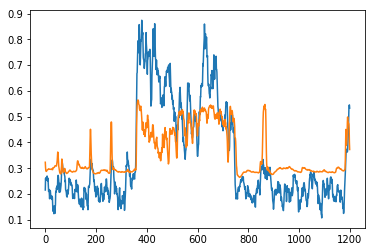

In [55]:
plot_comparison(start_idx=2, length=4000, train=False)